In [ ]:

import os
import numpy as np 
import pickle
import tensorflow as tf
from tensorflow.keras import models , Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Conv2D , MaxPooling2D   , Flatten
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.model_selection import train_test_split 
from keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input
import string
from pickle import load
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.merge import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu



### Loading images and captions

In [ ]:
! cp /content/drive/MyDrive/DeepLearning-Mahyar-McMaster/Project/Flickr_Data.zip .
!unzip '/content/Flickr_Data.zip'
!mkdir Flicker_Data
!mv  '/content/Images' Flicker_Data
!mv '/content/captions.txt' Flicker_Data

In [2]:

IMAGE_PATH = '/content/Flicker_Data/Images/'
CAPTION_PATH = '/content/Flicker_Data/captions.txt'
DESCRIPTIPN_PATH  = '/content/Flicker_Data/descriptions.txt'

Making a map between iamges and captions and their image names

In [6]:
def extract_images(directory):
 images = {}
 for name in tqdm(os.listdir(directory)):
  filename = directory + '/' + name
  image = load_img(filename, target_size=(64, 64))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)

  image_id = name.split('.')[0]
  images[image_id] = image

 return images

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping
 
 
images = extract_images(IMAGE_PATH)
filename = CAPTION_PATH
doc = load_doc(filename)
descriptions = load_descriptions(doc)
save_descriptions(descriptions, DESCRIPTIPN_PATH)


100%|██████████| 8091/8091 [00:44<00:00, 181.37it/s]


### Visualizing the images and their captions but here we just demostrated one image and its related captions but if you omit the break from for loop you will get all of the images with their captions

Captions for 3326454455_960e5442e9.jpg are as below:
['male soccer player wearing a red uniform jumping in the air and pulling up his shorts .', 'soccer player pulls his shorts up .', 'soccer player wearing a red costume makes an obscene gesture .', 'in red sports uniform and blue shoes jumping and pull up legs of shorts .', 'can see the white underwear of the man wearing the red soccer jersey because he is pulling up his shorts .']
Image 3326454455_960e5442e9.jpg is as below:


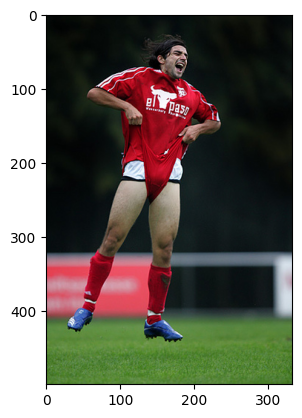

In [35]:
for key in images.keys():
    image = load_img(os.path.join(IMAGE_PATH, key + ".jpg"))
    print(f"Captions for {key + '.jpg'} are as below:")
    print(descriptions[key])
    print(f"Image {key + '.jpg'} is as below:")
    plt.imshow(image)
    break


### Preprocessing Methods

In [5]:
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# load photo images
def load_photo_images(Images, dataset):
	# load all images
	all_images = Images
	# filter features
	images = {k: all_images[k] for k in dataset}
	return images

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size , batch_size):

  X1, X2, y = list(), list(), list()
  n = 0
  for key, desc_list in descriptions.items():
    n += 1
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          if key != "":
                X1.append((photos[key][0]))
                X2.append(in_seq)
                y.append(out_seq)
    if n == batch_size: 
        X1, X2, y = np.asarray(X1), np.asarray(X2), np.asarray(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0      

  return np.asarray(X1), np.asarray(X2), np.asarray(y)

def create_sequences_for_testing(tokenizer, max_length, descriptions, photos, vocab_size):

  X1, X2, y = list(), list(), list()
  # walk through each image identifier
  n = 0
  for key, desc_list in descriptions.items():
    n += 1
    # walk through each description for the image
    for desc in desc_list:
      # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
         # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
          if key != "":
                X1.append((photos[key][0]))
                X2.append(in_seq)
                y.append(out_seq)

  return np.asarray(X1), np.asarray(X2), np.asarray(y)

### Building the customized CNN + LSTM model

In [13]:

def Build_CNN_LSTM(vocab_size, max_length):
      input1 = Input(shape=(64,64,3))
      conv1 = Conv2D(32, (3, 3), activation= tf.nn.relu, padding="same")(input1)
      max1 =  MaxPooling2D((2,2), (1,1))(conv1)
      conv2 = Conv2D(32, (3, 3), activation= tf.nn.relu, padding="same")(max1)
      max2 =  MaxPooling2D((2,2), (1,1))(conv2)
      flatten = Flatten()(max2)
      dropout1 = Dropout(0.5)(flatten)
      dense1 = Dense(64, activation = tf.nn.relu)(dropout1)
      input2 = Input(shape = (max_length,))
      embedding = Embedding(input_dim = vocab_size, output_dim = 64)(input2)
      dropout2 = Dropout(0.5)(embedding)
      lstm = LSTM(64)(dropout2)
      added = add([dense1, lstm])
      dense4 = Dense(64 , activation = tf.nn.relu)(added)
      output = Dense(vocab_size, activation = tf.nn.softmax)(dense4)
      model = Model(inputs = [input1 , input2], outputs = output)
      model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics = ["accuracy"])
      return model


### Preprocessing the Training and Validation data for training the model

In [8]:
clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
filename = "/content/Flicker_Data/Flickr_8k.trainImages.txt"
train = load_set(filename)
train_descriptions = load_clean_descriptions(DESCRIPTIPN_PATH, train)
train_images = load_photo_images(images, train)
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length(train_descriptions)
filename = "/content/Flicker_Data/Flickr_8k.devImages.txt"
test = load_set(filename)
test_descriptions = load_clean_descriptions(DESCRIPTIPN_PATH, test)
test_images = load_photo_images(images, test)


### Building the model and demosntrating it's Architecture

In [14]:
model = Build_CNN_LSTM(vocab_size, max_length)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 32)   896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 63, 63, 32)   9248        ['max_pooling2d_2[0][0]']        
                                                                                            

### Setting the parameters and runnig the CNN + LSTM model

In [15]:
epochs = 100
batch_size = 128
steps = len(train) // batch_size 
filepath = '/content/Flicker_Data/New_Model/model3-val_loss:_{val_loss:.3f}.h5'

for i in range(epochs):
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

  generator = create_sequences(tokenizer, max_length, train_descriptions, train_images, vocab_size, batch_size)
  test_generator =  create_sequences(tokenizer, max_length, test_descriptions, test_images, vocab_size, batch_size)
  model.fit(generator, epochs=1, verbose=1, steps_per_epoch = steps , validation_data=(test_generator) , callbacks= [early_stop, checkpoint])

46/46 [==============================] - ETA: 0s - loss: 10.1016 - accuracy: 0.0444
Epoch 1: val_loss improved from inf to 5.70138, saving model to /content/Flicker_Data/New_Model/model3-val_loss:_5.701.h5
46/46 [==============================] - ETA: 0s - loss: 5.6917 - accuracy: 0.0929
Epoch 1: val_loss improved from inf to 5.58477, saving model to /content/Flicker_Data/New_Model/model3-val_loss:_5.585.h5
46/46 [==============================] - ETA: 0s - loss: 5.6233 - accuracy: 0.0963
Epoch 1: val_loss improved from inf to 5.52003, saving model to /content/Flicker_Data/New_Model/model3-val_loss:_5.520.h5
46/46 [==============================] - ETA: 0s - loss: 5.5184 - accuracy: 0.1054
Epoch 1: val_loss improved from inf to 5.39855, saving model to /content/Flicker_Data/New_Model/model3-val_loss:_5.399.h5
46/46 [==============================] - ETA: 0s - loss: 5.3999 - accuracy: 0.1078
Epoch 1: val_loss improved from inf to 5.29926, saving model to /content/Flicker_Data/New_Model/

KeyboardInterrupt: ignored

### Defining the methods for evaluating the model

In [16]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    keys, actual, predicted = list(), list(), list()
    for key, desc_list in descriptions.items():
        keys.append(key)
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        if len(actual) < 20:
            actual.append(references)
            predicted.append(yhat.split())
        else:
            break
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    return actual , predicted, keys


### Loading the Test data for evaluating the model

In [19]:


filename = '/content/Flicker_Data/Flickr_8k.testImages.txt'
test = load_set(filename)
test_descriptions = load_clean_descriptions(DESCRIPTIPN_PATH, test)
test_images = load_photo_images(images, test)
model_filename = '/content/Flicker_Data/New_Model/model3-val_loss:_3.917.h5'


### Loading the trained model and evaulatig it's performance

In [20]:

model = load_model(model_filename)

test_tokenizer = create_tokenizer(test_descriptions)
actual, predicted, keys = evaluate_model(model, test_descriptions, test_images, test_tokenizer, max_length)
xtest1, xtest2, ytest = create_sequences_for_testing(test_tokenizer, max_length, test_descriptions, test_images, vocab_size)
_, accuracy = model.evaluate([xtest1,xtest2], ytest)
print(f"Model acurracy is {accuracy}%")

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.506384
BLEU-2: 0.180349
BLEU-3: 0.074868
BLEU-4: 0.000000
1698/1698 [==============================] - 10s 6ms/step - loss: 7.5943 - accuracy: 0.1270
Model acurracy is 0.1270083785057068%


### Showing the Actual caption, ?Predicted Caption and Actual picture for some of the samples

Actual Captions
0th actual caption: ['startseq', 'lady', 'and', 'a', 'man', 'with', 'no', 'shirt', 'sit', 'on', 'a', 'dock', '.', 'endseq']
1th actual caption: ['startseq', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'dock', 'together', '.', 'endseq']
2th actual caption: ['startseq', 'man', 'and', 'a', 'woman', 'sitting', 'on', 'a', 'dock', '.', 'endseq']
3th actual caption: ['startseq', 'man', 'and', 'woman', 'sitting', 'on', 'a', 'deck', 'next', 'to', 'a', 'lake', '.', 'endseq']
4th actual caption: ['startseq', 'shirtless', 'man', 'and', 'a', 'woman', 'sitting', 'on', 'a', 'dock', '.', 'endseq']
Predicted Caption:
Predicted caption: ['startseq', 'man', 'in', 'a', 'playing', 'shirt', 'is', 'for', 'a', 'tennis', 'on', 'a', 'park', 'endseq']


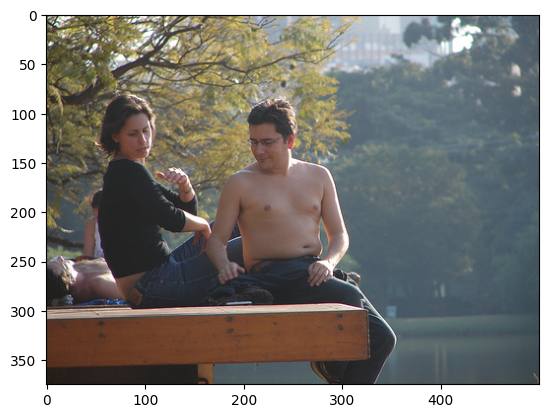

In [24]:
item = 2
print("Actual Captions")
for i in range(len(actual[item])):
    print(f"{i}th actual caption: {actual[item][i]}")

print("Predicted Caption:")
print(f"Predicted caption: {predicted[item]}")
image = load_img(os.path.join(IMAGE_PATH, keys[item] + ".jpg"))
plt.imshow(image)